**DIE ANOTHER DATA: AN EXPLORATORY DATA ANALYSIS OF JAMES BOND FILMS**

Name: Sadbh Boylan

NetID: sboylan

In [1]:
#import statements

#import pandas library
import pandas as pd

#import numpy library
import numpy as np

#import statsmodel api
import statsmodels.api as sm

#import seaborn library
import seaborn as sb

#import linear regression function
from sklearn.linear_model import LinearRegression

#import matplotlib
import matplotlib.pyplot as plt

#import plotly express
import plotly.express as px

#import jupyter widgets
import ipywidgets

#Accessing functions
from ipywidgets import interact, IntSlider

from IPython.display import display, clear_output

I started out with one primary database file aquired from Kaggle. https://www.kaggle.com/datasets/dreb87/jamesbond 

Initially, I worked with two other datasets from TMDB and Spotify APIs, but as I progressed I found that my work took off 
using the primary dataset only, and there was no need for these data sources.

Using a combination of OpenRefine and Excel, I assessed what initial cleaning was needed regarding, particularly regarding location. As I progressed through my workflow, a number of issues emerged, including:

-The data used both "Great Britain" and "United Kingdom" to refer to locations. As most locations were listed by country,
I altered all instances of "Great Britain" to "United Kingdom" (this also ensured all locations were viewed with the same lens of 
granularity). Annoyingly, there were also occurrences of England and Scotland specifically. To keep things consistent across entries (i.e.
prevent some records referring specifically to England or Scotland and others to the United Kingdom in general), I removed all instances of these
locations and ensured United Kingdom was listed instead if it was not already present. Although this did result in some data loss,
it was a necessary evil to ensure consistency across the datapoints.

-For similar reasons, West Berlin was replaced with Germany in instances it occurred.

-Cube was incorrectly entered as a location - I corrected this to Cuba.


In [2]:
#read in CSV file acquired from kaggle
primaryBondDataset = pd.read_csv("jamesbond-locationsCleaned.csv")


However, I did spend some time extracting out information from the primary dataset. Although I initially began with one file, I created further tables through my workflow.

The next step involved collecting a table of all the unique locations featured across all of the films - either as depicted locations or shooting locations. 

In [3]:
depictedLocations = primaryBondDataset["Depicted_Film_Loc"]
filmingLocations = primaryBondDataset["Shooting_Loc"]
uniqueListOfDepictedLocations = []

#I extracted the relevant columns and effectively looped through them to collect all unique values

for x in range(0,len(depictedLocations)):
    filmLocations = depictedLocations[x]

    filmLocationsList = filmLocations.split(",")
    for y in range(0,len(filmLocationsList)):
        location = filmLocationsList[y].strip()
        if location in uniqueListOfDepictedLocations:
            continue
        else:
            uniqueListOfDepictedLocations.append(location)

for x in range(0,len(filmingLocations)):
    shootingLocations = filmingLocations[x]

    shootingLocationsList = shootingLocations.split(",")
    for y in range(0,len(shootingLocationsList)):
        location = shootingLocationsList[y].strip()
        if location in uniqueListOfDepictedLocations:
            continue
        else:
            uniqueListOfDepictedLocations.append(location)


locationCols = ["Location"]

#I converted this information to a dataframe that could then be converted to a csv file
locationDf = pd.DataFrame(uniqueListOfDepictedLocations, columns= locationCols)

JBLocationZip = dict(method = "zip",archive_name = "JBLocationZip.csv")

#locationDf.to_csv("JBLocationZip.zip", compression = JBLocationZip)

For mapping purposes, I then decided to gather latitude and longitude data - I did this by obtaining an additional csv datasource and merging the files using SQLite through DB Browser, with data sourced from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state?resource=download 


The result at this point was a table/Excel file with all unique locations and their longitude and latitude coordinates, as well as a unique location_id for each record added in Excel. I implemented the location_id to prevent any future issues with entering country names, as troubleshooting errors with incorrect entries to this point had been a real hinderance to progress.

I then wanted to create a new table with 

1. Film_ID
2. Decade of release
3. No. of Depicted Locations
4. Array of Depicted Locations (given by location_id)
5. No. of Filming Locations
6. Array of Filming Locations (given by location_id)

I also wanted to add additional columns to the primary dataset to account for the Decade in which the film was released, provide a unique Film_ID for consistent referencing across tables, and calculate an aggregated user score that would represent the average score across both IMDB and Rotten Tomatoes.

In [4]:
#loading the desired data from file
#At this point, I was working with the file that had been merged and cleaned with DB Browser and Excel
jamesBondMainDataset = primaryBondDataset

#loading locations dataset
#This file had been cleaned with Excel, and listed the unique location values
locationWithCoOrds = pd.read_csv("locationWithCoOrds.csv")

#I pulled the location_ids to be used as keys, and the location names for values
keyList = list(locationWithCoOrds["location_id"])
valueList = list(locationWithCoOrds["location"])

#initalising empty lists
idArray = []
depictedLocationsCountArray = []
depictedLocationsArray = []
filmingLocationsCountArray = []
filmingLocationsArray = []

#From the main dataset, I pulled the Depicted_Film_Loc and Shooting_Loc columns and converted
#them to dictionaries to allow me to work with them as a list of lists.
depictedLocationsFilmDict = jamesBondMainDataset["Depicted_Film_Loc"].to_dict()
filmingLocationsFilmDict = jamesBondMainDataset["Shooting_Loc"].to_dict()

#I added a new decade column to reflect each film's decade of release
jamesBondMainDataset["Decade"] = (jamesBondMainDataset["Year"]//10)*10

#I also stored this as an array
decadeArray = jamesBondMainDataset["Decade"] 

#In the for loops below, I tried to tackle a few issues at once!

#The first step was to alter the primary dataset to include a film_ID that would allow me
#to identify records across tables.

#for each film in the dataset, the title and the year of release are extracted
#and combined as a string to create a new ID

#These IDs are stored in the idArray

for i in range(0,len(jamesBondMainDataset["Movie"])):
    yearOfRelease = str(jamesBondMainDataset["Year"][i])
    idArray.append(jamesBondMainDataset["Movie"][i] + "_" + yearOfRelease)

    #Below, for each record, I accessed the list of depicted locations and shooting locations.
    #I converted both of these to lists for later use.
    #I also counted the number of elements in the list (i.e. how many locations)
    #to make count varibales for the number of depicted locations and shooting
    #locations per film.

    depictedLocationsFilmList = (depictedLocationsFilmDict[i]).split(",")
    depictedLocationsFilmCount = len(depictedLocationsFilmList)
    depictedLocationsCountArray.append(depictedLocationsFilmCount)

    shootingLocationsFilmList = (filmingLocationsFilmDict[i]).split(",")
    shootingLocationsFilmCount = len(shootingLocationsFilmList)
    filmingLocationsCountArray.append(shootingLocationsFilmCount)

#Additionally, in the for loops below, I replaced instances of a location in the depictedLocationsFilmList
#and shootingLocationsFilmList with their location_ids

    for j in range(0, depictedLocationsFilmCount):
        currentLocation = depictedLocationsFilmList[j].strip()
        locationIDPosition = valueList.index(currentLocation)
        depictedLocationsFilmList[j] = keyList[locationIDPosition]
    depictedLocationsArray.append(depictedLocationsFilmList)


    for k in range(0, shootingLocationsFilmCount):
        currentLocation = shootingLocationsFilmList[k].strip()
        locationIDPosition = valueList.index(currentLocation)
        shootingLocationsFilmList[k] = keyList[locationIDPosition]
    filmingLocationsArray.append(shootingLocationsFilmList)
    

#I added a new column to the primary dataset to add the new IDs

jamesBondMainDataset["Film_ID"] = idArray

#I also added an additional column for aggregate user score across platforms

jamesBondMainDataset["Avg_User_Rating"] = (jamesBondMainDataset["Avg_User_IMDB"] + jamesBondMainDataset["Avg_User_Rtn_Tom"])/2

# show updated dataframe
#display(jamesBondMainDataset.head())

filmIDColumn = jamesBondMainDataset["Film_ID"]

#I created a new dictionary using the information compiled above 
locationsTableData = {'Film': list(jamesBondMainDataset["Movie"]),
        'Number of Depicted Locations': depictedLocationsCountArray,
        "Depicted Locations": depictedLocationsArray,
        "Number of Shooting Locations": filmingLocationsCountArray,
        "Shooting Locations": filmingLocationsArray
        }

#This dictionary could then be converted to a dataframe,
#which was then converted to a new csv file
newLocationsdf = pd.DataFrame(locationsTableData, index=idArray)
display(newLocationsdf.head())

#jamesBondLocationsTable = dict(method = "zip",archive_name = "jamesBondLocationsTableClean.csv")
#newLocationsdf.to_csv("jamesBondLocationsTableClean.zip", compression = jamesBondLocationsTable)

#jamesBondMainDatasetdf = dict(method = "zip",archive_name = "jamesBondMainClean.csv")
#jamesBondMainDataset.to_csv("jamesBondMainClean.zip", compression = jamesBondMainDatasetdf)

,Film,Number of Depicted Locations,Depicted Locations,Number of Shooting Locations,Shooting Locations
Dr. No_1962,Dr. No,2,"[0, 18]",2,"[0, 18]"
From Russia with Love_1963,From Russia with Love,5,"[0, 1, 2, 3, 4]",4,"[0, 4, 6, 1]"
Goldfinger_1964,Goldfinger,3,"[5, 0, 6]",3,"[0, 6, 5]"
Thunderball_1965,Thunderball,4,"[7, 0, 8, 5]",4,"[0, 7, 8, 5]"
You Only Live Twice_1967,You Only Live Twice,5,"[5, 9, 10, 11, 12]",3,"[12, 23, 11]"


As I started to experiment with different visualisations (particularly maps), I realised it would be useful to also have the 
3 letter country codes for each location. Much like the longitude and latitude coordinates, I merged two tables with DB Browser
to achieve this using a csv source from dnb: https://docs.dnb.com/partner/en-US/iso_country_codes 

This also required some troubleshooting and fixes on Excel - some countries were listed differently across the two tables I used and didn't match up correctly in the merge (e.g. Russian Federation vs Russia, People's Republic of Korea vs North Korea, etc.)

I also wanted to add another variable to my unique locations table to count how many times each location was used as a depicted or shooting location.


In [5]:

#loading the desired data from file
jamesBondLocationsDataset = pd.read_csv("jamesBondLocationsTableClean.csv")

#unique locations file
uniqueLocations = locationWithCoOrds

location_IDs = uniqueLocations["location_id"]

#I initialised a dictionary that would keep track of instances of a 
#particular location_id, with the location_id as the key and
#the count as the value
depictedCountDict = {str(x) : "0" for x in location_IDs}

depictedLocationsList = jamesBondLocationsDataset["Depicted Locations"]

#Although it took some roundabout solutions, I managed to update my dictionary to count
#how many times each location was used as a depicted location

for rowDep in range(0, len(depictedLocationsList)):
     
     #The rows first had to be cleaned so they could be converted to lists 
     currentDepictedLocation = depictedLocationsList[rowDep].strip("[]")
     currentDepictedLocationList = currentDepictedLocation.split(",")
     noOfLocations = len(currentDepictedLocationList)

     for locationDep in range(0, noOfLocations):

          #I cleaned the location strings again to allow me to index them easily
          locationString = str(currentDepictedLocationList[locationDep])
          locationStripped = locationString.strip()

          #Once I obtained the index, I was able to update the count variable
          locationCountOccurrence = str(depictedCountDict.get(locationStripped))
          locationCountOccurrence = int(locationCountOccurrence) + 1
     
          #This change was then reflected in the dictionary
          depictedCountDict[locationStripped] = locationCountOccurrence


#I then repeated the process for shooting locations

shootingCountDict = {str(x) : "0" for x in location_IDs}

shootingLocationsList = jamesBondLocationsDataset["Shooting Locations"]

for rowSho in range(0, len(shootingLocationsList)):
     
     currentShootingLocation = shootingLocationsList[rowSho].strip("[]")
     currentShootingLocationList = currentShootingLocation.split(",")
     noOfLocations = len(currentShootingLocationList)

     for locationSho in range(0, noOfLocations):
          locationString = str(currentShootingLocationList[locationSho])
          locationStripped = locationString.strip()
          
          locationCountOccurrence = str(shootingCountDict.get(locationStripped))
          locationCountOccurrence = int(locationCountOccurrence) + 1
    
          shootingCountDict[locationStripped] = locationCountOccurrence
     

#I now also had counts for how many times each location was used as a depicted and shooting location
#These were added as new columns to the unique locations table
uniqueLocations["No of Depictions"] = depictedCountDict.values()

uniqueLocations["No of Shoots Used"] = shootingCountDict.values()


#This table was then convertred to a new csv file

#JBUniqueLocationZip = dict(method = "zip",archive_name = "JBUniqueLocationZip.csv")
#uniqueLocations.to_csv("JBUniqueLocationZip.zip", compression = JBUniqueLocationZip)

For later visualisations, I defined functions that would allow me to count how frequently each location was used as a depicted or shooting location in each decade and add them to the unique locations table.

In [6]:
def depictedLocationsSubset(jamesBond_locations, jamesBondMainDataset, uniqueLocations, decade):

     #Taking smaller sections of data - i.e. by decade
     decadeSubset = jamesBondMainDataset[jamesBondMainDataset["Decade"] == decade]
     decadeSubsetIDs = decadeSubset["Film_ID"]
    
    #Using the film IDs, I was able to cross reference with the locations by film table and extract
    #the necessary information.

     decadeLocations = jamesBond_locations[jamesBond_locations["Film_ID"].isin(decadeSubsetIDs)]

     location_IDs = uniqueLocations["location_id"]

     #As before, initialised a new dictionary to keep track of occurences 
     depictedCountDictDecade = {str(x) : "0" for x in location_IDs}

     #I also converted the depicted locations column to a list
     depictedLocationsListDecade = decadeLocations["Depicted Locations"].tolist()
    

     #The remaining process is much the same as the initial count of location use across all films, only this
     #time with a focus on the specific decade provided to the function
     
     for rowDepDecade in range(0, len(depictedLocationsListDecade)):
          
          currentDepictedLocationDecade = depictedLocationsListDecade[rowDepDecade].strip("[]")
          
          currentDepictedLocationListDecade = currentDepictedLocationDecade.split(",")
         
          noOfLocationsDecade = len(currentDepictedLocationListDecade)

          for locationDepDecade in range(0, noOfLocationsDecade):
               locationStringDecade = str(currentDepictedLocationListDecade[locationDepDecade])
               locationStrippedDecade = locationStringDecade.strip()
              
               locationCountOccurrenceDecade = depictedCountDictDecade.get(locationStrippedDecade)
               locationCountOccurrenceDecade = int(locationCountOccurrenceDecade) + 1
     
               depictedCountDictDecade[locationStrippedDecade] = locationCountOccurrenceDecade

     columnTitle = "Depictions_"+str(decade)
     uniqueLocations[columnTitle] = depictedCountDictDecade.values()

     return uniqueLocations

#The same workflow as before was applied for the shooting locations

def shootingLocationsSubset(jamesBond_locations, jamesBondMainDataset, uniqueLocations, decade):
     
     #Taking smaller sections of data - i.e. by decade
     decadeSubset = jamesBondMainDataset[jamesBondMainDataset["Decade"] == decade]

     #I parsed the IDs from the subset
     decadeSubsetIDs = decadeSubset["Film_ID"]

     #I extracted the depicted locations for the films whose IDs were in the subset
     decadeLocations = jamesBond_locations[jamesBond_locations["Film_ID"].isin(decadeSubsetIDs)]

     #I also extracted the entire list of unique location IDs
     location_IDs = uniqueLocations["location_id"]

     #As before, initialised a new dictionary to keep track of occurences 
     shootingCountDictDecade = {str(x) : "0" for x in location_IDs}

     #I converted the shooting locations column to a list
     shootingLocationsListDecade = decadeLocations["Shooting Locations"].tolist()

     #The same process used for depicted locations is applied here too

     for rowShootDecade in range(0, len(shootingLocationsListDecade)):
          
          currentShootingLocationDecade = shootingLocationsListDecade[rowShootDecade].strip("[]")
          currentShootingLocationListDecade = currentShootingLocationDecade.split(",")
          noOfLocationsDecade = len(currentShootingLocationListDecade)

          for locationShootDecade in range(0, noOfLocationsDecade):
               locationStringDecade = str(currentShootingLocationListDecade[locationShootDecade])
               locationStrippedDecade = locationStringDecade.strip()
               
               locationCountOccurrenceDecade = shootingCountDictDecade.get(locationStrippedDecade)
               locationCountOccurrenceDecade = int(locationCountOccurrenceDecade) + 1
     
               shootingCountDictDecade[locationStrippedDecade] = locationCountOccurrenceDecade

     columnTitle = "Shooting_"+str(decade)
     uniqueLocations[columnTitle] = shootingCountDictDecade.values()

     return uniqueLocations

To then actually generate this data, I called the functions repeatedly using a for loop and updated the relevant table.

In [7]:
for decadeCheck in range(1960,2011,10):
    #I called the previously defined functions for each decade to populate the table
    uniqueLocationsTemp = depictedLocationsSubset(jamesBondLocationsDataset, jamesBondMainDataset, uniqueLocations, decadeCheck)
    uniqueLocations = uniqueLocationsTemp
    uniqueLocationsTemp = shootingLocationsSubset(jamesBondLocationsDataset, jamesBondMainDataset, uniqueLocations, decadeCheck)
    uniqueLocations = uniqueLocationsTemp

#This was then converted to a csv file for future reference
uniqueLocationsDecadeZip = dict(method = "zip",archive_name = "uniqueLocationsWithDecade.csv")
uniqueLocations.to_csv("uniqueLocationsWithDecade.zip", compression = uniqueLocationsDecadeZip)


I then moved to do some exploratory analysis with a linear regression model, looking in particular at fitting a Y variable of the Average User IMDB score.

I generated a correlation matrix to quickly check that no two variables were perfectly correlated.

In [8]:
#JBcorrelationMatrix = primaryBondDataset.corr()

JBDataForRegression = jamesBondMainDataset


I also generated a pairs plot to help identify any potential correlations worth investigating - though
it was difficult to make sense of such a large matrix, and I recognised that I needed to refine
the variables I was considerating significantly 

In [9]:
#sb.pairplot(JBcorrelationMatrix)

Initially, I dropped the following variables as part of my first round of feature selection:
- Year - a unique value for each record, not useful
- Movie - again, a unique value for each record
- Writer - this involved multiple people per project, and although there was some overlap of names involved, the combinations were practically unique
- Depicted_Film_Loc - unique values
- Shooting_Loc - unique values
- Bond_Girl_Nat - unique values
- Avg_User_Rtn_Tom - a metric that wasn't useful as a predictor (was highly correlated with Avg_User_IMDB anyway)
- Top_100 - similarly, a metric that wasn't going to be useful as a predictor

In [10]:
#JBDataForRegression.drop(["Year","Movie","Writer","Depicted_Film_Loc","Shooting_Loc","Bond_Girl_Nat","Avg_User_Rtn_Tom","Top_100"], axis = 1, inplace = True)

#regressionWithDummies = pd.get_dummies(JBDataForRegression)

#regressionWithDummies

Even with these features eliminated from the regression, it was still difficult to gain any clear inference from the regression model.

I trialled other approaches and combinations of variables, though found that the coefficient values tended to be relatively small across the board. There wasn't a lot to support the idea of a robust linear model, and I found a lot of the variables were adding unnecessary complexity

For this reason, I refined the variables I was looking at significantly to those that I abitrarily deemed significant, based on a combination of preconceived expectations of relevance to IMDB Score and values generated in previous models.

As such, the variables I considered in my final linear regression model were:
Budget_Adj
Film_length
Conquests
Martinis
BJB
Kills_Bond
Kills_Others
Video_Game
Bond
Bond_Car_MFG


C:\Users\sadbh\AppData\Local\Temp\ipykernel_24156\3405957496.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  reducedRegressionWithoutDummiesCorr = JBDataReducedForRegression.corr()


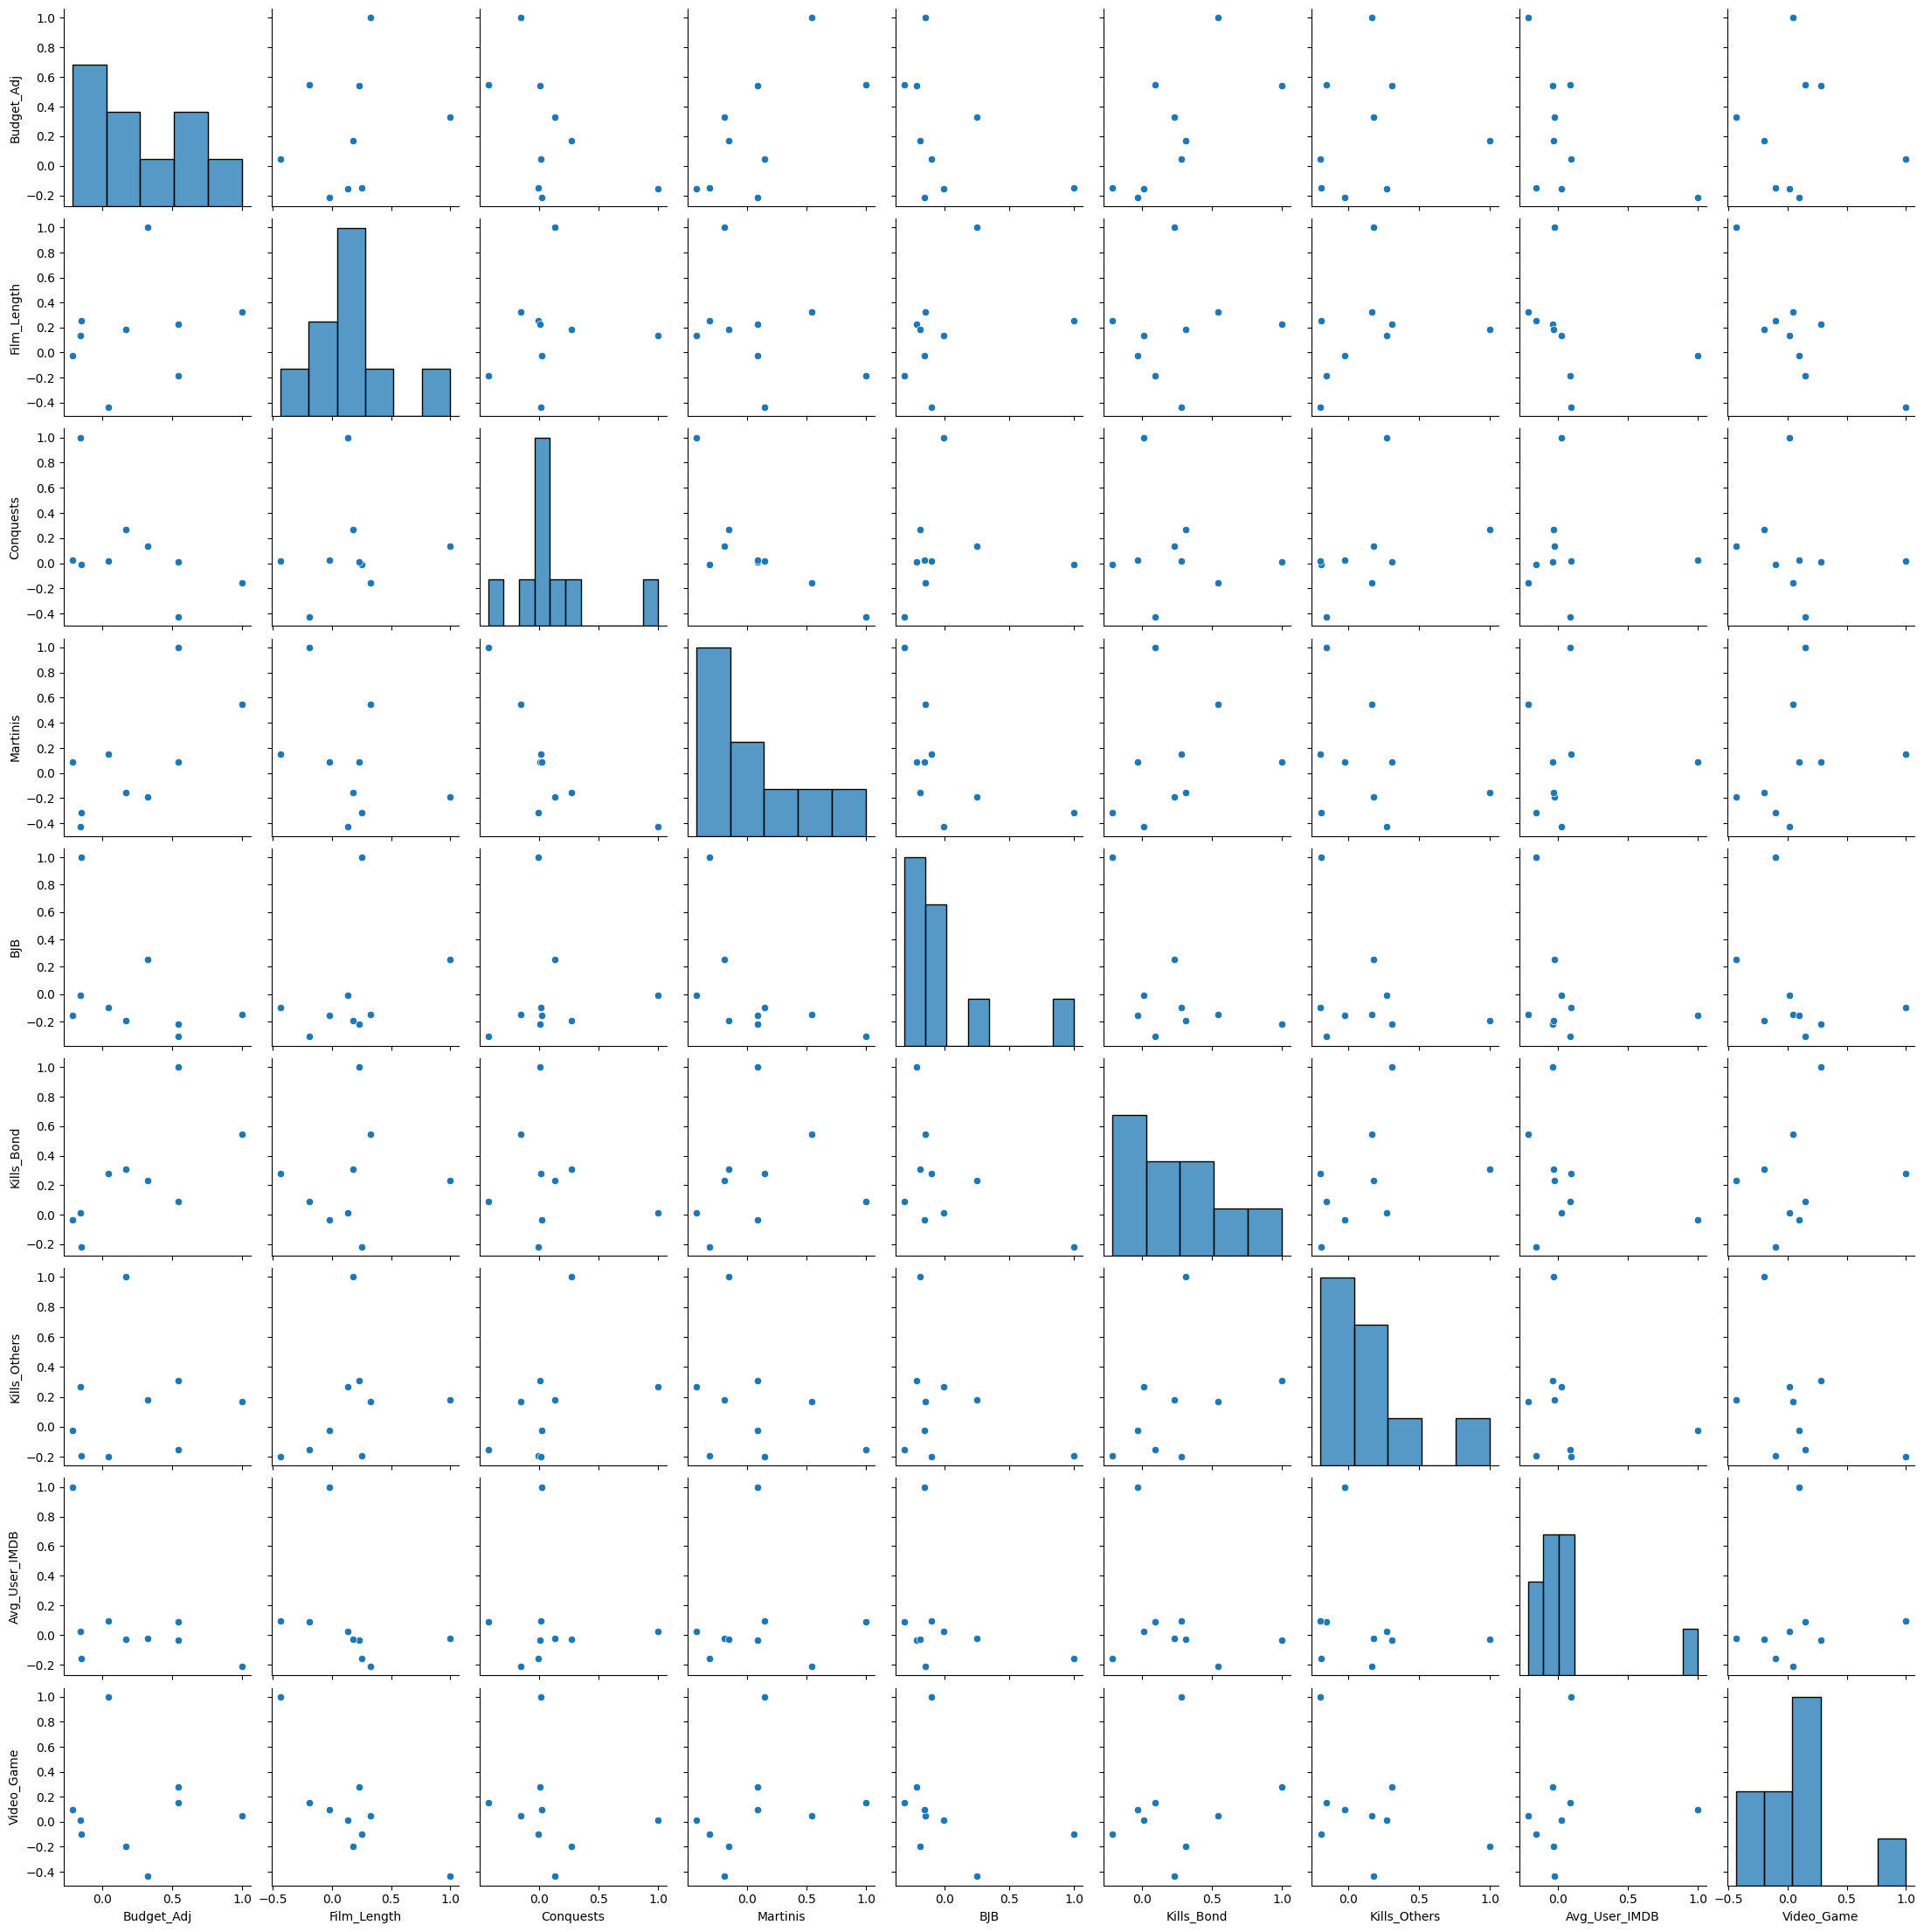

In [11]:
JBDataReducedForRegression = jamesBondMainDataset[["Budget_Adj","Film_Length","Conquests","Martinis","BJB","Kills_Bond","Kills_Others","Avg_User_IMDB","Video_Game","Bond","Bond_Car_MFG"]]

#For visualisation purposes, I generated the pairsplot without the dummy variables for categorical variables
#as the addition of these variables made it too large to be useful and took a very long time to generate!
reducedRegressionWithoutDummiesCorr = JBDataReducedForRegression.corr()

sb.pairplot(reducedRegressionWithoutDummiesCorr)

regressionReducedWithDummies = pd.get_dummies(JBDataReducedForRegression)

#As evident in the pairs plot, there isn't a particularly strong correlation across any of the regression variables with the
# y variable Avg_User_IMDB

In [12]:
#Generating the model

#creating a linear regression object
linearRegressionReduced = LinearRegression()

#Storing the x variables
xVariablesReduced = regressionReducedWithDummies.columns.values

#I located the y variable and removed it from the regression model
yIndex = np.where(xVariablesReduced == "Avg_User_IMDB")[0][0]

#Removing the y variable from the list of variables
xVariablesReduced = np.delete(xVariablesReduced,yIndex)

#I removed two of the dummy variables for each of the categorical variables to ensure the model was fit correctly.
craigIndex = np.where(xVariablesReduced == "Bond_Daniel Craig")[0][0]

xVariablesReduced = np.delete(xVariablesReduced,craigIndex)

lotusIndex = np.where(xVariablesReduced == "Bond_Car_MFG_Lotus")[0][0]

xVariablesReduced = np.delete(xVariablesReduced,lotusIndex)

#Fitting the model
linearRegressionReduced.fit(regressionReducedWithDummies[xVariablesReduced],regressionReducedWithDummies["Avg_User_IMDB"])

#Rounding the coefficients to six decimal places for easier interpretation
roundedCoefficientsReduced = np.round(linearRegressionReduced.coef_,6)

cdf2 = pd.DataFrame(roundedCoefficientsReduced, xVariablesReduced, columns=['Coefficients'])


print("The intercept of the regression is: ",linearRegressionReduced.intercept_)
print("\nGeneral Vars:\n",cdf2[0:8])
print("\nBond:\n",cdf2[8:13])
print("\nBond Car:\n",cdf2[13:24])

#Unfortunately, still not a particularly useful model!

The intercept of the regression is:  8.582692640054656

General Vars:
               Coefficients
Budget_Adj       -0.000009
Film_Length      -0.007220
Conquests         0.374695
Martinis          0.142533
BJB               0.472518
Kills_Bond        0.041309
Kills_Others     -0.004401
Video_Game       -0.088014

Bond:
                      Coefficients
Bond_George Lazenby     -1.282390
Bond_Pierce Brosnan     -2.041053
Bond_Roger Moore        -2.526544
Bond_Sean Connery       -0.952416
Bond_Timothy Dalton     -1.399956

Bond Car:
                            Coefficients
Bond_Car_MFG_AMC               0.124471
Bond_Car_MFG_Aston Martin     -0.658618
Bond_Car_MFG_BMW              -0.701774
Bond_Car_MFG_Bajaj             0.304861
Bond_Car_MFG_Bently           -0.960371
Bond_Car_MFG_Citroën           0.014344
Bond_Car_MFG_Ford             -0.650010
Bond_Car_MFG_Mercury          -1.282390
Bond_Car_MFG_Rolls Royce      -0.736789
Bond_Car_MFG_Sunbeam          -1.479690
Bond_Car_MFG_Toyota   

The intercept of the regression is:  8.582692640054656

General Vars:
               Coefficients

Budget_Adj       -0.000009

Film_Length      -0.007220

Conquests         0.374695

Martinis          0.142533

BJB               0.472518

Kills_Bond        0.041309

Kills_Others     -0.004401

Video_Game       -0.088014

Bond:
                      Coefficients

Bond_George Lazenby     -1.282390

Bond_Pierce Brosnan     -2.041053

Bond_Roger Moore        -2.526544

Bond_Sean Connery       -0.952416

Bond_Timothy Dalton     -1.399956

Bond Car:
                            Coefficients

Bond_Car_MFG_AMC               0.124471

Bond_Car_MFG_Aston Martin     -0.658618

Bond_Car_MFG_BMW              -0.701774

Bond_Car_MFG_Bajaj             0.304861

Bond_Car_MFG_Bently           -0.960371

Bond_Car_MFG_Citroën           0.014344

Bond_Car_MFG_Ford             -0.650010

Bond_Car_MFG_Mercury          -1.282390

Bond_Car_MFG_Rolls Royce      -0.736789

Bond_Car_MFG_Sunbeam          -1.479690

Bond_Car_MFG_Toyota           -0.664886

The intercept is quite high here, though I imagine much of this is down to the removal of the Bond_Daniel Craig variable, as Craig's Bond films bring the average IMDB rating across films up. The addition of any of the remaining Bond actor dummy variables brings the predicted score down (Brosnan and Moore suffer in particular from poorly rated outings to have a strong negative effect on the average user IMDB score).

Similarly, the majority of Bond car models have a negative impact on IMDB score, though there is very little data to draw on here. Many of the car brands appeared in only one or two films, so it isn't a robut predictor here.

Interestingly, the typical Bond cliches - number of 'conquests'/romantic affairs, martinis downed, and instances of "Bond, James Bond" all have a positive impact on the average user IMDB score. When it comes to appealing to the audience, it appears it pays off to stick with what you know!

I was suprised that Budget_adj had a negative impact on the user IMDB score, albeit a barely negligible one. The number of kills by Bond per film does actually increase the user IMDB score, reflecting the idea that IMDB scores favour the grittier, contemporary Bond flicks, again most closely correlated with Craig in the role. The same is not true of the numbe of kills by characters that aren't Bond, and additionallly, a longer film length comes at the detriment of user scores.

Overall, this is by no means a particularly robust model, but it was interesting to conduct this as an exploratory exercise to investigate what correlations could be present!

**EXPLORATORY VISUALISATIONS AND ANALYSIS**

While getting to grips with the various python libraries and tools, I generated a lot of exploratory visualisations to help me make sense of the data.

As I progressed, I found the most substance and interesting visualisations came from comparisons across Bond actors and in the investigation of shooting and depicted locations. Given the globe-trotting nature of the films, there was a lot of variety in the data and scope for interesting visualisations.

In [13]:
#Defining the Bond colour map for future use and consistency
bondColourMap = {"Sean Connery": "#ED0000", "George Lazenby": "#1C358A", "Roger Moore": "black", "Timothy Dalton":"#1B8A29", "Pierce Brosnan": "#7B7D7D", "Daniel Craig": "#D4AC0D"}


In [14]:
#BOND ACTOR QUANTITATIVE ANALYSIS

#Average World Adj Gross
jamesBondMainDataset[["Bond","World_Adj"]].groupby("Bond").mean()


,World_Adj
Bond,
Daniel Craig,827588.000000
George Lazenby,518736.000000
Pierce Brosnan,523901.750000
Roger Moore,564809.428571
Sean Connery,745559.666667
Timothy Dalton,341575.000000


<Axes: title={'center': 'Dalton Adj. Gross'}>

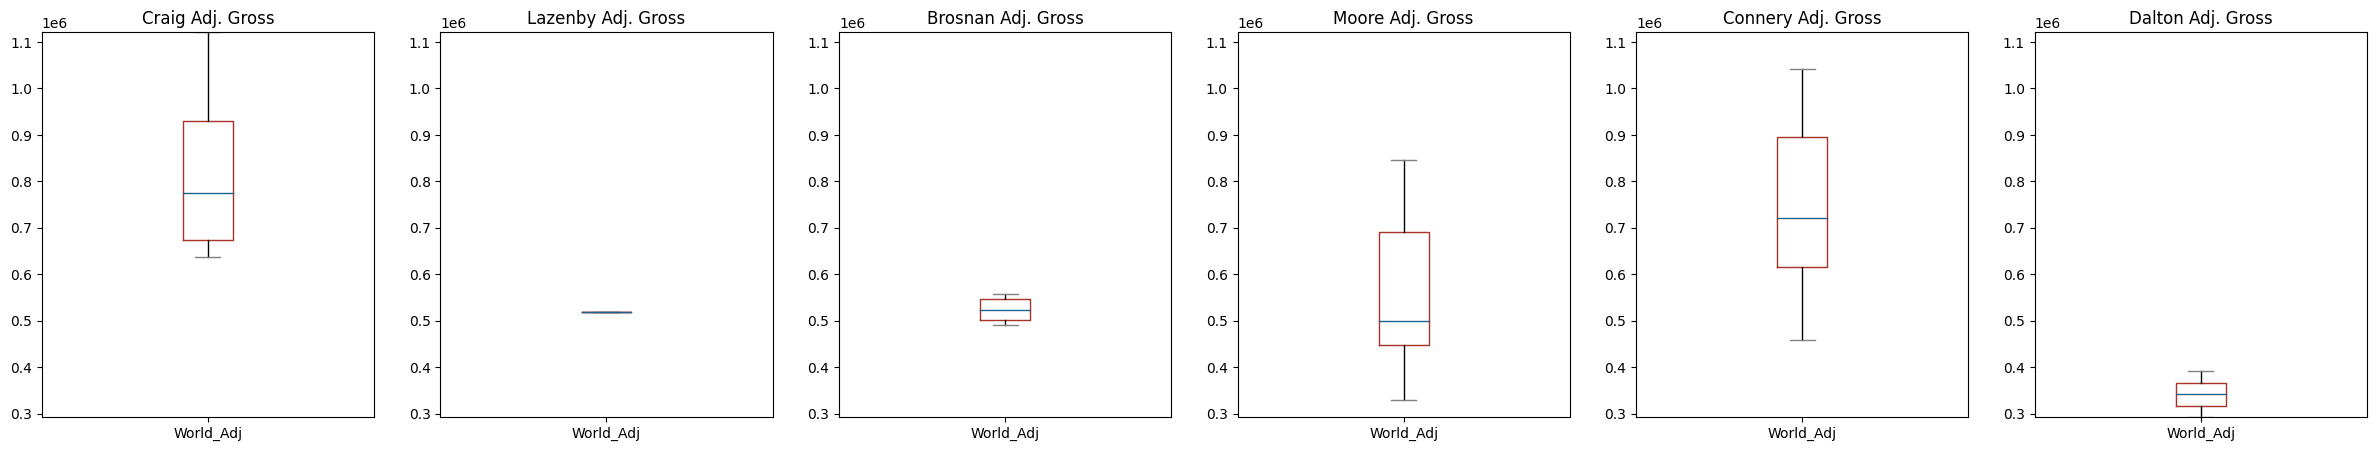

In [15]:
#COMPARING ADJUSTED GROSS ACROSS ACTORS

#extracting data
bondActorAdjGross = jamesBondMainDataset[["Bond","World_Adj"]].groupby("Bond")

#converting grouped data to data frame
bondActorAdjGross = pd.DataFrame(bondActorAdjGross)

#defining colours for boxplots
colourSelection = {"boxes": "#A93226", "whiskers": "black", "medians": "#1F618D", "caps": "Gray",}

#generating figure with six axes for six boxplots
figRunTime, (axCraig, axLazenby, axBrosnan, axMoore, axConnery, axDalton) = plt.subplots(nrows = 1, ncols = 6, figsize = (30,5))

#generating a boxplot for the adj box office gross for each Bond actor
bondActorAdjGross.iloc[0][1].plot.box(ax = axCraig, title = "Craig Adj. Gross", ylim = (292392,1120980), color = colourSelection)
bondActorAdjGross.iloc[1][1].plot.box(ax = axLazenby, title = "Lazenby Adj. Gross", ylim = (292392,1120980), color = colourSelection)
bondActorAdjGross.iloc[2][1].plot.box(ax = axBrosnan, title = "Brosnan Adj. Gross", ylim = (292392,1120980), color = colourSelection)
bondActorAdjGross.iloc[3][1].plot.box(ax = axMoore, title = "Moore Adj. Gross", ylim = (292392,1120980), color = colourSelection)
bondActorAdjGross.iloc[4][1].plot.box(ax = axConnery, title = "Connery Adj. Gross", ylim = (292392,1120980), color = colourSelection)
bondActorAdjGross.iloc[5][1].plot.box(ax = axDalton, title = "Dalton Adj. Gross", ylim = (292392,1120980), color = colourSelection)

The average adjusted gross across actors shows the peaks and troughs in the popularity of the film series. The early Connery films performed strongly, while the actors that followed, Lazenby and Moore, saw something of a decline. While Lazenby only appeared as Bond once, Moore's average is brought down by some very low grosses despite some well-performing flicks. The lowest point came with Dalton, before there was something of a revival with the Brosnan era. However, the financial performance of the Craig films blows the others out of the water, providing concrete proof of the benefits of the Craig-led rebrand.

In [16]:
#USER SCORE ANALYSIS PER ACTOR

jamesBondMainDataset.groupby("Bond").agg(

    {
        "Avg_User_IMDB" : ["min","max","median","mean"],
        "Avg_User_Rtn_Tom" : ["min","max","median","mean"],

    }
)

Avg_User_IMDB                       Avg_User_Rtn_Tom       \
                         min  max median      mean              min  max   
Bond                                                                       
Daniel Craig             6.7  7.9   7.30  7.300000              6.1  8.2   
George Lazenby           6.8  6.8   6.80  6.800000              6.7  6.7   
Pierce Brosnan           6.0  7.2   6.35  6.475000              5.7  6.9   
Roger Moore              6.2  7.1   6.70  6.614286              4.7  6.8   
Sean Connery             6.7  7.8   7.15  7.200000              6.3  8.4   
Timothy Dalton           6.5  6.7   6.60  6.600000              6.0  6.3   

                                 
               median      mean  
Bond                             
Daniel Craig     7.10  7.125000  
George Lazenby   6.70  6.700000  
Pierce Brosnan   6.05  6.175000  
Roger Moore      5.70  5.685714  
Sean Connery     7.25  7.250000  
Timothy Dalton   6.15  6.150000

Looking at the average user scores, they follow typically the same pattern as the financial earnings, with a slight difference in that Dalton's outings were actually rated better on average than Brosnan's despite performing worse financially. It may be the case that these films were deemed to have "aged better", and public opinion over time grew to favour Dalton's outings rather than Brosnan's, even if couldn't draw audiences at the time of theatrical release.

<Axes: title={'center': 'No. of Depicted & Shooting Locations for James Bond Films'}, xlabel='Film', ylabel='Number of Locations'>

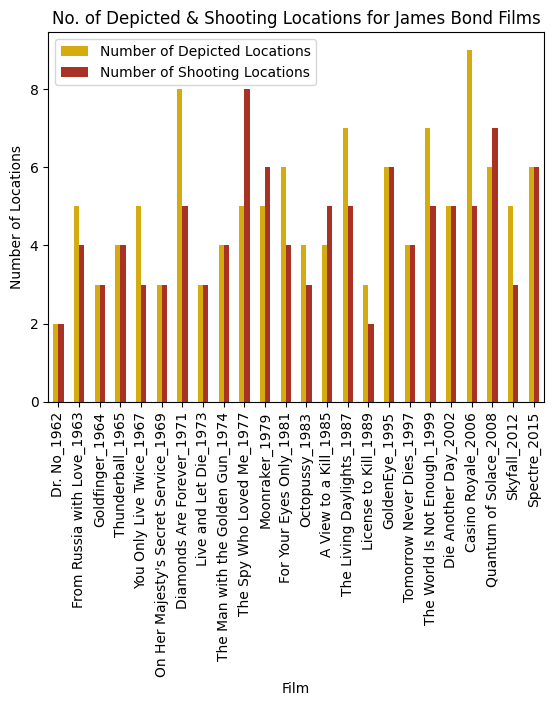

In [17]:
#NUMBER OF DEPICTED/SHOOTING LOCATIONS ACROSS FILMS

jamesBond_locations = pd.read_csv("jamesBondLocationsTableClean.csv", index_col = 0)

#extracting data to be plotted
locationsCount = jamesBond_locations[["Number of Depicted Locations","Number of Shooting Locations"]]

#generating grouped barchart
locationsCount.plot.bar(color = ["#D4AC0D","#A93226"], title = "No. of Depicted & Shooting Locations for James Bond Films", xlabel = "Film", ylabel = "Number of Locations")


Text(0.5, 0.98, 'World Adj Gross vs Budget Adj per Bond Actor')

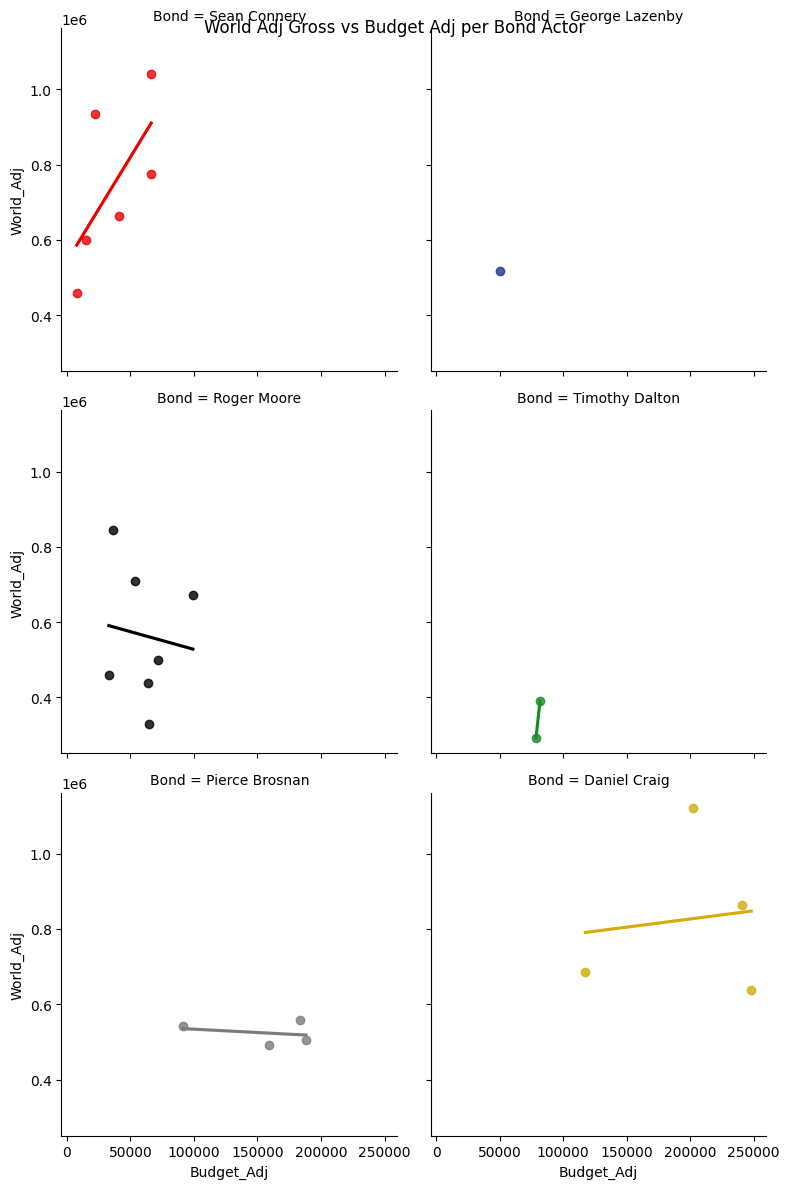

In [18]:
#BUDGET ADJ VS ADJ GROSS FOR BOND ACTORS

#Defining the Bond colour map for future use and consistency
bondColourMap = {"Sean Connery": "#ED0000", "George Lazenby": "#1C358A", "Roger Moore": "black", "Timothy Dalton":"#1B8A29", "Pierce Brosnan": "#7B7D7D", "Daniel Craig": "#D4AC0D"}


grossVbudget = sb.lmplot(data = jamesBondMainDataset, x="Budget_Adj",y="World_Adj",col="Bond",hue="Bond", col_wrap=2, palette = bondColourMap, ci = None,
height = 4)
grossVbudgetFig = grossVbudget.fig
grossVbudgetFig.suptitle("World Adj Gross vs Budget Adj per Bond Actor")



Typically, there is a positive linear relationship between a film's adjusted global gross and adjusted budget, though Moore and, to a lesser extent, Brosnan are exceptions to this, suggesting that this is not a certain positive relationship.

In [19]:
#BOND CLICHE VISUALISATION

#Aggregating martini data by Bond actor
martiniData = jamesBondMainDataset.groupby("Bond")["Martinis"].sum()

#Aggregating instances of "Bond, James Bond" by actor
BJBData = jamesBondMainDataset.groupby("Bond")["BJB"].sum()

#Collecting unique Bond actor values
bondArray = jamesBondMainDataset["Bond"].unique()

#Compiling cliche data into a dictionary
contentData = {
               "Martinis": martiniData,
              "Bond, James Bond": BJBData }

#Converting cliche data dictionary to a pandas dataframe
contentDataframe = pd.DataFrame(contentData)

#Generating figure
figCliches = px.bar(contentDataframe, y = ["Martinis","Bond, James Bond"], title="Bond Cliches per Actor", color_discrete_map = {"Martinis":"#99AE40", "Bond, James Bond": "black" })

#Updating layout of figure
figCliches.update_layout(xaxis_title="Actor",yaxis_title = "No. of Occurrences", legend_title = "Cliches")

#Displaying figure
figCliches.show()

This visualisation was just for fun to see how often each actor indulged in the standard Bond cliches of drinking a martini and introducing themselves as "Bond, James Bond." Craig is a clear winner for most martinis consumed, but Moore claims the BJB title, stealing it from original actor Connery.

In [20]:
#BUBBLE PLOT OF FINANCIAL/CRITICAL FIGURES 

#creating dictionary from main dataset
bubblePlotData = {"Film_ID": list(jamesBondMainDataset["Film_ID"]),
                      "Bond": list(jamesBondMainDataset["Bond"]),
        "Adj_Gross": list(jamesBondMainDataset["World_Adj"]),
        "Avg_User_Rating": list(jamesBondMainDataset["Avg_User_Rating"]),
        "Budget_Adj": list(jamesBondMainDataset["Budget_Adj"])
        }

#converting dictionary to dataframe
bubblePlotDataDF = pd.DataFrame(bubblePlotData)

#creating bubble plot
figBubble = px.scatter(bubblePlotData, x = "Adj_Gross", y = "Avg_User_Rating", title = "Adjusted Gross vs Avg User Rating per Bond Film",size = "Budget_Adj", color = "Bond", color_discrete_map = bondColourMap, hover_name = "Film_ID")

#figBubble["layout"].pop("updatemenus")
#adjusting layout of graph
figBubble.update_layout(xaxis_title = "Adjusted Global Gross ('000 2013 USD)", yaxis_title = "Avg User Rating (IMDB & Rotten Tomatoes)")

#displaying the figure
figBubble.show()

To look more closely at rating and gross per actor, I implemented an interactive map that would display films by actor to allow for closer inspection (unfortunately some moving of the graph is required to view the Dalton points due to their outlier status)

In [21]:
#BUBBLE PLOT OF FINANCIAL/CRITICAL FIGURES WITH INTERACTIVITY

#creating dictionary from main dataset
bubblePlotData = {"Film_ID": list(jamesBondMainDataset["Film_ID"]),
                      "Bond": list(jamesBondMainDataset["Bond"]),
        "Adj_Gross": list(jamesBondMainDataset["World_Adj"]),
        "Avg_User_Rating": list(jamesBondMainDataset["Avg_User_Rating"]),
        "Budget_Adj": list(jamesBondMainDataset["Budget_Adj"])
        }

#converting dictionary to dataframe
bubblePlotDataDF = pd.DataFrame(bubblePlotData)

#creating bubble plot
figBubbleInt = px.scatter(bubblePlotData, x = "Adj_Gross", y = "Avg_User_Rating", title = "Adjusted Gross vs Avg User Rating per Bond Film",size = "Budget_Adj",color="Bond", animation_frame = "Bond", color_discrete_map = bondColourMap, hover_name = "Film_ID")

figBubbleInt["layout"].pop("updatemenus")

#adjusting layout of graph
figBubbleInt.update_layout(xaxis_title = "Adjusted Global Gross ('000 2013 USD)", yaxis_title = "Avg User Rating (IMDB & Rotten Tomatoes)", showlegend = False)

#displaying the figure
figBubbleInt.show()

I then focused on creating map visualisations to represent depicted and shooting location data. First, I created visualisations to represent the frequency of locations across all films in the series as both depicted and shooting locations.

In [24]:
#DEPICTED LOCATIONS MAP

#reading in map data (compiled in final project file!)
mapDataAllFilms = pd.read_csv("uniqueLocationsWithDecade.csv")

mapDepicted = mapDataAllFilms[(mapDataAllFilms["No of Depictions"] > 0)]
#generating map
figMapDep = px.choropleth(mapDepicted, locations="ISO3-DigitAlphaCountryCode",
                    color="No of Depictions", 
                    hover_name="location", 
                    hover_data = "No of Depictions",
                    color_continuous_scale=px.colors.sequential.Reds)


#updating figure layout
figMapDep.update_layout(title = "Depicted Locations Across all James Bond Films")

#displaying figure
figMapDep.show()

In [25]:
#SHOOTING LOCATIONS MAP

mapShooting = mapDataAllFilms[(mapDataAllFilms["No of Shoots Used"] > 0)]

figMapShot = px.choropleth(mapShooting, locations="ISO3-DigitAlphaCountryCode",
                    color="No of Shoots Used", # lifeExp is a column of gapminder
                    hover_name="location", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.ice)

#updating figure layout
figMapShot.update_layout(title = "Shooting Locations Across all James Bond Films")


figMapShot.show()

There's quite an overlap across the two maps, though they are not identical. Russia, for instance, has been depicted 9 times, but only 1 film actually shot there. African countries have also been depicted more than they have actually been used as shooting locations; it is interesting to consider if this is owed to practical challenges or lack of incentives to film there. The most interesting insight for me was the fact that the United Kingdom has been depicted 23 times, but interestingly, there is a single film where it wasn't a shooting location. I cross-checked this with the original data and found that the film in question is "You Only Live Twice", released in 1967 and starring Sean Connery was Bond. It is something of an outlier in that it diverges significantly from Ian Fleming's novel of the same name, and is primarily set in Japan. Still, there's something just a little odd about a James Bond film not filming in the motherland at all!

To attempt to represent all of this information on the same plot, I also generated a bubble plot to communicate the same information.

In [26]:
#DEPICTED AND SHOOTING LOCATIONS PLOT

#setting access token
px.set_mapbox_access_token("pk.eyJ1Ijoic2JveWxhbiIsImEiOiJjbGdlNmhxNTIyaG9kM2dxcjk5ZnNmYnUwIn0.TBRkjL9k1teRts2I00M8mQ")


#generating plot
figMapBoxLoc = px.scatter_mapbox(mapDataAllFilms, lat="latitude", lon="longitude", size="No of Depictions", color="No of Shoots Used", hover_name = "location", hover_data = ["No of Depictions","No of Shoots Used"], color_continuous_scale= px.colors.sequential.Hot, size_max= 30, zoom = 1,
                                 )

#updating figure layout
figMapBoxLoc.update_layout(title = "Locations Across James Bond Films (Depicted & Shooting Locations)")

# show figure
figMapBoxLoc.show()

Finally, I wanted to focus closely on the countries that occurred most frequently across the data, both as a whole and over time.

To help with this, I defined a function to help plot the top ten locations depicted across the films in a given decade.

In [27]:
#This function uses the decade provided by the Jupyter widget and extracts the relevant
#depiction for that decade and plots how frequently the top 10 locations appeared

def plottingCountryDepictionByDecade(Decade):
    columnName = "Depictions_"+str(Decade)
    uniqueLocations = pd.read_csv("uniqueLocationsWithDecade.csv")
    data = uniqueLocations.sort_values(by = columnName, ascending = False).head(10)
    x = data["location"]
    y = data[columnName]

    plt.bar(x,y, color = "indianred")
    plt.xticks(rotation = 90)
    plt.xlabel("Location")
    plt.ylabel("No. of Occurrences")
    plt.title("Top Depicted Locations ("+str(Decade)+")")

In [28]:
ipywidgets.interact(plottingCountryDepictionByDecade, Decade = (1960, 2010, 10,), description = "Decade")

interactive(children=(IntSlider(value=1980, description='Decade', max=2010, min=1960, step=10), Output()), _do…

<function __main__.plottingCountryDepictionByDecade(Decade)>

I then repeated the same process for shooting locations.

In [29]:
#As before, the relevant data based on the widget slider decade is selected here and the top 10 shooting
#locations are displayed in a bar chart.

def plottingShootingCountries(Decade):
    columnName = "Shooting_"+str(Decade)
    uniqueLocations = pd.read_csv("uniqueLocationsWithDecade.csv")
    data = uniqueLocations.sort_values(by = columnName, ascending = False).head(10)
    x = data["location"]
    y = data[columnName]

    plt.bar(x,y, color = "black")
    plt.xticks(rotation = 90)
    plt.xlabel("Location")
    plt.ylabel("No. of Occurrences")
    plt.title("Top Shooting Locations ("+str(Decade)+")")

In [30]:
ipywidgets.interact(plottingShootingCountries, Decade = (1960, 2010, 10,), description = "Decade")

interactive(children=(IntSlider(value=1980, description='Decade', max=2010, min=1960, step=10), Output()), _do…

<function __main__.plottingShootingCountries(Decade)>

Finally, I looked at representing the most frequent locations used across all films. To provide additional context and make for a more interesting visualisation, I represented both the number of depictions and number of shoots for the top ten countries in both depictions and shoot locations.

In [31]:
#To allow me to plot the data, these columns were converted to integer values
uniqueLocations["No of Depictions"] = uniqueLocations["No of Depictions"].astype(int)
uniqueLocations["No of Shoots Used"] = uniqueLocations["No of Shoots Used"].astype(int)

#The top 10 most-depicted locations are extracted here and plotted in a histrogram (alongside how frequently they were used as a shooting location)
uniqueLocationsTop10Depicted = uniqueLocations.sort_values(by = "No of Depictions", ascending = False).head(10)
figTopTenDepicted = px.histogram(uniqueLocationsTop10Depicted, x = "location", y = ["No of Depictions", "No of Shoots Used"], barmode = "group",
                                 title = "Use of Top Ten Depicted Locations Across All Films",
                                 color_discrete_sequence=["indianred","black"])

figTopTenDepicted.update_layout(xaxis_title = "Location",yaxis_title = "Frequency", legend_title = "Key")
figTopTenDepicted.show()

#The top 10 most used shooting locations are extracted here and plotted in a histrogram (alongside how frequently they were depicted)
uniqueLocationsTop10Shooting = uniqueLocations.sort_values(by = "No of Shoots Used", ascending = False).head(10)
figTopTenShooting = px.histogram(uniqueLocationsTop10Shooting, x = "location", y = ["No of Depictions", "No of Shoots Used"], barmode = "group",
                                 title = "Use of Top Ten Shooting Locations Across All Films",
                                 color_discrete_sequence=["indianred","black"])

figTopTenShooting.update_layout(xaxis_title = "Location",yaxis_title = "Frequency", legend_title = "Key")
figTopTenShooting.show()


I was surprised by the lack of overlap of countries here - I had previously expected the top ten countries in both cases to be the same. There appears to be greater concentration in a smaller number of locations for shooting locations than there is for depicted locations, which makes sense given the practical challenges of filming across the world.

**Reflection**

At the end of this project, the final result is far different from what I had initially planned. I had done considerable work with different APIs (TMDB and Spotify) to gather a wider pool of data to work from, however as I progressed I dropped these from the project completely. I also diverged almost entirely from the objectives outlined in my initial proposal, with very few of them making their way into the completed project. I adapted much of my work as I realised where the meatier information was that lent itself well to the visualisation methods we had covered in class. I was also very conscious, as I referenced in my initial data source identification assignment, to avoid overlap with a similar project by Derek S. Young, who previously published a visualisation project based on James Bond data published in Chance. His Bond R Data Package was cited as a source for the Kaggle dataset that I did work with, so I indirectly was able to apply his data collection for my own project work. 

By far, as referenced throughout this project, my greatest challenge was cleaning the data and wrangling it in a way that would allow me to represent it visually. Occasionally, I would also get tripped up by wrangling the data in a way that couldn't be translated to a visualisation method. I found that the best approach was to carefully think about the visualisation I wanted to create first, and then work back from there to clarify what inputs it would require. For more complicated wrangling, I also adopted an iterative approach, typically starting with a simplified, functioning version and adapting it to meet more sophisticated requirements. This was the case for the functions to find the top 10 depicted and top 10 shooting locations. I first cracked the visualisation for the top 10 depicted locations across all films, and recycled the code to find the top 10 shooting locations. Then, I was able to adjust this and add Jupyter widgets to allow for interaction and the same visualisation by decade. The addition of Jupyter widgets proved problematic in itself, and it took significant troubleshooting and some re-working and adjustment of the workflow to actually provide the correct functionality. The same could be said of my data cleaning process overall - much of the data cleaning was done as the need arose, and although I presented it in a more step-by-step process here, in reality the data cleaning, wrangling, and visualisation stages were not so cleanly separated.

In the interest of transparency and accredition, as has been a major theme in this semester's readings, I maintained a list of sources that I have attached below. I frequently consulted official documentation and class notes to troubleshoot issues, though also utilised a number of internet sources. 

Overall, I feel I have truly benefitted from my work on this project. I have been able to develop my skills in Python and various libraries further, as well as refine my thought process when it comes to data visualisation in general. Informed by the readings, I did my best to adhere to both good design practices and the principles of data feminism, and feel confident that I will be able to carry these considerations into future projects.




**Sources**

https://www.kaggle.com/datasets/dreb87/jamesbond 

https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state?resource=download 

https://docs.dnb.com/partner/en-US/iso_country_codes 

https://www.scaler.com/topics/how-to-create-a-csv-file-in-python/

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html 

https://www.w3schools.com/python/pandas/pandas_csv.asp 

https://medium.com/@polanitzer/building-a-linear-regression-in-python-step-by-step-94caeb0a4f18

https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c#:~:text=Multiple%20linear%20regression%20accepts%20not,dummy%20variable%20using%20the%20pandas

https://www.statsmodels.org/stable/user-guide.html

https://scikit-learn.org/stable/

https://www.geeksforgeeks.org/principal-component-analysis-with-python/

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.Series.str.replace.html 

https://colab.research.google.com/drive/1YZVVOXAkxEr3x5k5cOB07nARfQ4gcGhA?usp=sharing

https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values

https://github.com/kwaldenphd/eoc-final-project-resources

https://medium.com/nerd-for-tech/enriching-data-visualizations-with-annotations-in-plotly-using-python-6127ff6e0f80

https://www.geeksforgeeks.org/python-plotly-tutorial/

https://towardsdatascience.com/query-pandas-dataframe-with-sql-2bb7a509793d#:~:text=Pandasql%20is%20a%20python%20library,the%20SQLite%20table%20using%20SQL.

https://towardsdatascience.com/4-python-packages-to-create-interactive-dashboards-d50861d1117e

https://github.com/jupyter-widgets/ipywidgets/blob/main/docs/source/examples/Index.ipynb

https://github.com/jupyter-widgets/ipywidgets/tree/511663a56324cea5324f49a65ebe25e2f1b04d87/docs/source/examples

https://ipywidgets.readthedocs.io/en/stable/

https://plotly.com/python/plotly-express/

https://plotly.com/python/sliders/#sliders-in-plotly-express

https://www.youtube.com/watch?v=jWT-HXv0LUQ
